In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import xarray as xr
import pandas as pd
from scipy.cluster.hierarchy import linkage
from datetime import datetime
from tqdm.notebook import tqdm


In [2]:
ENERGY_PATH = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'
WINDOW = 7

In [3]:
def add_filename(ds, variable):
    # Extract the filename from the 'source' attribute, which is automatically set by open_mfdataset
    filename = os.path.basename(ds.encoding['source'])
    
    # Extract the characters that match the '???' part of the filename
    identifier = filename.split('_')[0]
    
    # Add the identifier as a new coordinate to the dataset
    ds = ds.assign_coords(country_name=identifier)
    if variable == 'sun':
        ds = ds['pv_util'] + ds['pv_roof']
    elif variable == 'wind':
        ds = ds['wind_offshore'] + ds['wind_onshore']
    else:
        ds = ds[variable]

    return ds

variable = 'residual' # option 2: total_RE

#TODO: Implement 7 day moving average, and weekly sampling of that!

#TODO: Do this in a function
data_res = xr.open_mfdataset(ENERGY_PATH + '???' + '_LENTIS_PD_02_v4.nc', combine='nested', concat_dim='country', preprocess=lambda ds: add_filename(ds, 'residual'))
data_res = data_res.where(data_res['time'].dt.month.isin([12, 1, 2]), drop=True)
data_res = data_res.drop_sel(country = [0, 19, 23, 28, 38]) # drop countries that are not properly represented in the analysis
# data_res = data_res.rolling(time = WINDOW, center = True).mean().dropna(dim='time')
res_stacked = data_res.stack(event=('runs', 'time'))
res_rank = res_stacked.compute().rank(dim = 'event', pct = True)
if variable == 'total_RE': # for production, we want to invert the ranking
    res_rank = 1 - res_rank

Regime part messing around

In [4]:
df_all = pd.read_csv(f"../Results/clusters_v0/clusters_all.csv")
df_all = df_all[['time', 'run', 'cluster_id']]
df_all['time'] = pd.to_datetime(df_all['time'])
df_all['time'] = df_all['time'].apply(lambda dt: dt.replace(hour=12, minute=0, second=0)) # set time to noon, to match df_xr. Is daily average anyway
df_all

,time,run,cluster_id
0,2000-01-01 12:00:00,10,3
1,2000-01-02 12:00:00,10,3
2,2000-01-03 12:00:00,10,3
3,2000-01-04 12:00:00,10,3
4,2000-01-05 12:00:00,10,3
...,...,...,...
143995,2009-12-27 12:00:00,169,2
143996,2009-12-28 12:00:00,169,2
143997,2009-12-29 12:00:00,169,2
143998,2009-12-30 12:00:00,169,2


In [5]:
df_xr = res_rank.to_dataframe().reset_index(drop = True)
df_xr['run'] = df_xr['runs'].str.extract('(\d+)').astype(int)
df_xr = df_xr.drop('runs', axis = 1)

In [6]:
df_xr = pd.merge(df_xr, df_all[['time', 'run', 'cluster_id']], on=['time', 'run'], how='left') # merge both df's on correct time and run

In [7]:
date = pd.to_datetime("2005-02-11")
date = date.replace(hour=12, minute=0, second=0)
df_xr.query('time == @date and run == 10')

,country_name,time,residual,run,cluster_id
462,AUT,2005-02-11 12:00:00,0.409557,10,2.0
135022,BEL,2005-02-11 12:00:00,0.655462,10,2.0
269582,BGR,2005-02-11 12:00:00,0.430537,10,2.0
404142,BIH,2005-02-11 12:00:00,0.436950,10,2.0
538702,CHE,2005-02-11 12:00:00,0.616268,10,2.0
673262,CYP,2005-02-11 12:00:00,0.822332,10,2.0
807822,CZE,2005-02-11 12:00:00,0.538474,10,2.0
942382,DEU,2005-02-11 12:00:00,0.719107,10,2.0
1076942,DNK,2005-02-11 12:00:00,0.565881,10,2.0
1211502,ESP,2005-02-11 12:00:00,0.634802,10,2.0


In [8]:
nl_naoplus = df_xr.query('country_name == "NLD" and cluster_id == 1')
nl_naoplus['residual'].mean(), nl_naoplus['residual'].std()

(0.3449630303664446, 0.25276778944923933)

In [9]:
nl_naomin = df_xr.query('country_name == "NLD" and cluster_id == 0')
nl_naomin['residual'].mean(), nl_naomin['residual'].std()

(0.5680110745440046, 0.27688594132115474)

In [10]:
nl_atlantic = df_xr.query('country_name == "NLD" and cluster_id == 2')
nl_atlantic['residual'].mean(), nl_atlantic['residual'].std()

(0.6089679624532433, 0.2651310663752746)

In [11]:
nl_blocking = df_xr.query('country_name == "NLD" and cluster_id == 3')
nl_blocking['residual'].mean(), nl_blocking['residual'].std()

(0.5041121069685442, 0.28458635448466707)

In [12]:
def cluster_histogram_list(df_xr, country_list, ax):
    df_mild = df_xr[df_xr['country_name'].isin(country_list) & df_xr['residual'].between(0.9, 0.95)]
    df_moderate = df_xr[df_xr['country_name'].isin(country_list) & df_xr['residual'].between(0.95, 0.975)]
    df_severe = df_xr[df_xr['country_name'].isin(country_list) & df_xr['residual'].between(0.975, 0.99)]
    df_extreme = df_xr[df_xr['country_name'].isin(country_list) & (df_xr['residual'] >= 0.99)]

    n, bins, patches = ax.hist([df_mild['cluster_id'], df_moderate['cluster_id'], df_severe['cluster_id'], df_extreme['cluster_id']], 
                                bins = np.linspace(-.5, 3.5, 5), 
                                stacked=True, 
                                rwidth=0.5,
                                color=['C0', 'C2', 'C1', 'C3'],
                                label=['Mild', 'Moderate', 'Severe', 'Extreme'])
    
    # Calculate percentage per case
    for i, df in enumerate([df_mild, df_moderate, df_severe, df_extreme]):
        total = len(df)
        for cluster_id in [0, 1, 2, 3]:
            percentage = len(df[df['cluster_id'] == cluster_id]) / total * 100
            height = n[i][cluster_id]
            if i > 0:
                prevheight = n[i-1][cluster_id]
            elif i == 0:
                prevheight = 0
            ax.text(cluster_id, (height + prevheight)/2, f'{percentage:.1f}%', ha='center', va='center')

    # Calculate total percentages for all cases combined
    total_cases = len(df_xr[(df_xr['country_name'].isin(country_list)) & (df_xr['residual'] > 0.9)])
    percentages = []
    for cluster_id in [0, 1, 2, 3]:
        total_percentage = len(df_xr[(df_xr['cluster_id'] == cluster_id) & df_xr['country_name'].isin(country_list) & (df_xr['residual'] > 0.9)]) / total_cases * 100
        percentages.append(total_percentage)

    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels([f'NAO - ({percentages[0]:.1f}%)', f'NAO + ({percentages[1]:.1f}%)', f'Blocking ({percentages[2]:.1f}%)', f'Atl. Ridge ({percentages[3]:.1f}%)'])
    ax.set_ylabel('# of events')

    ax.set_title(f'WR distribution with energy droughts for {", ".join(country_list)}')

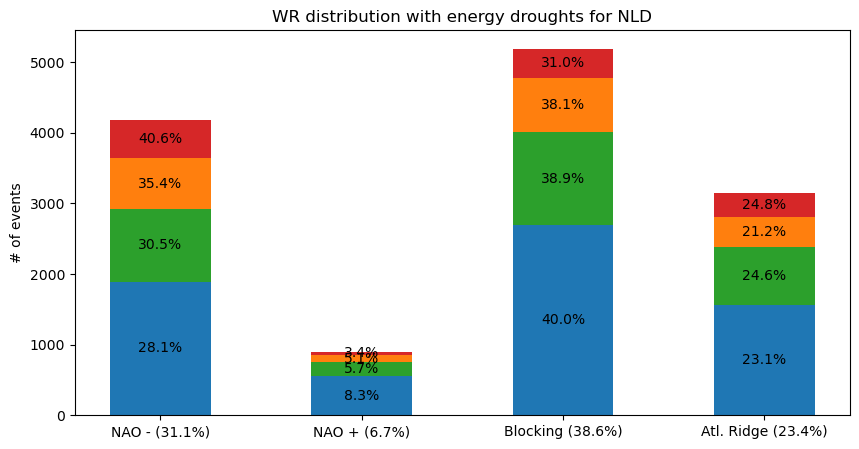

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
cluster_histogram_list(df_xr, ['NLD'], ax)

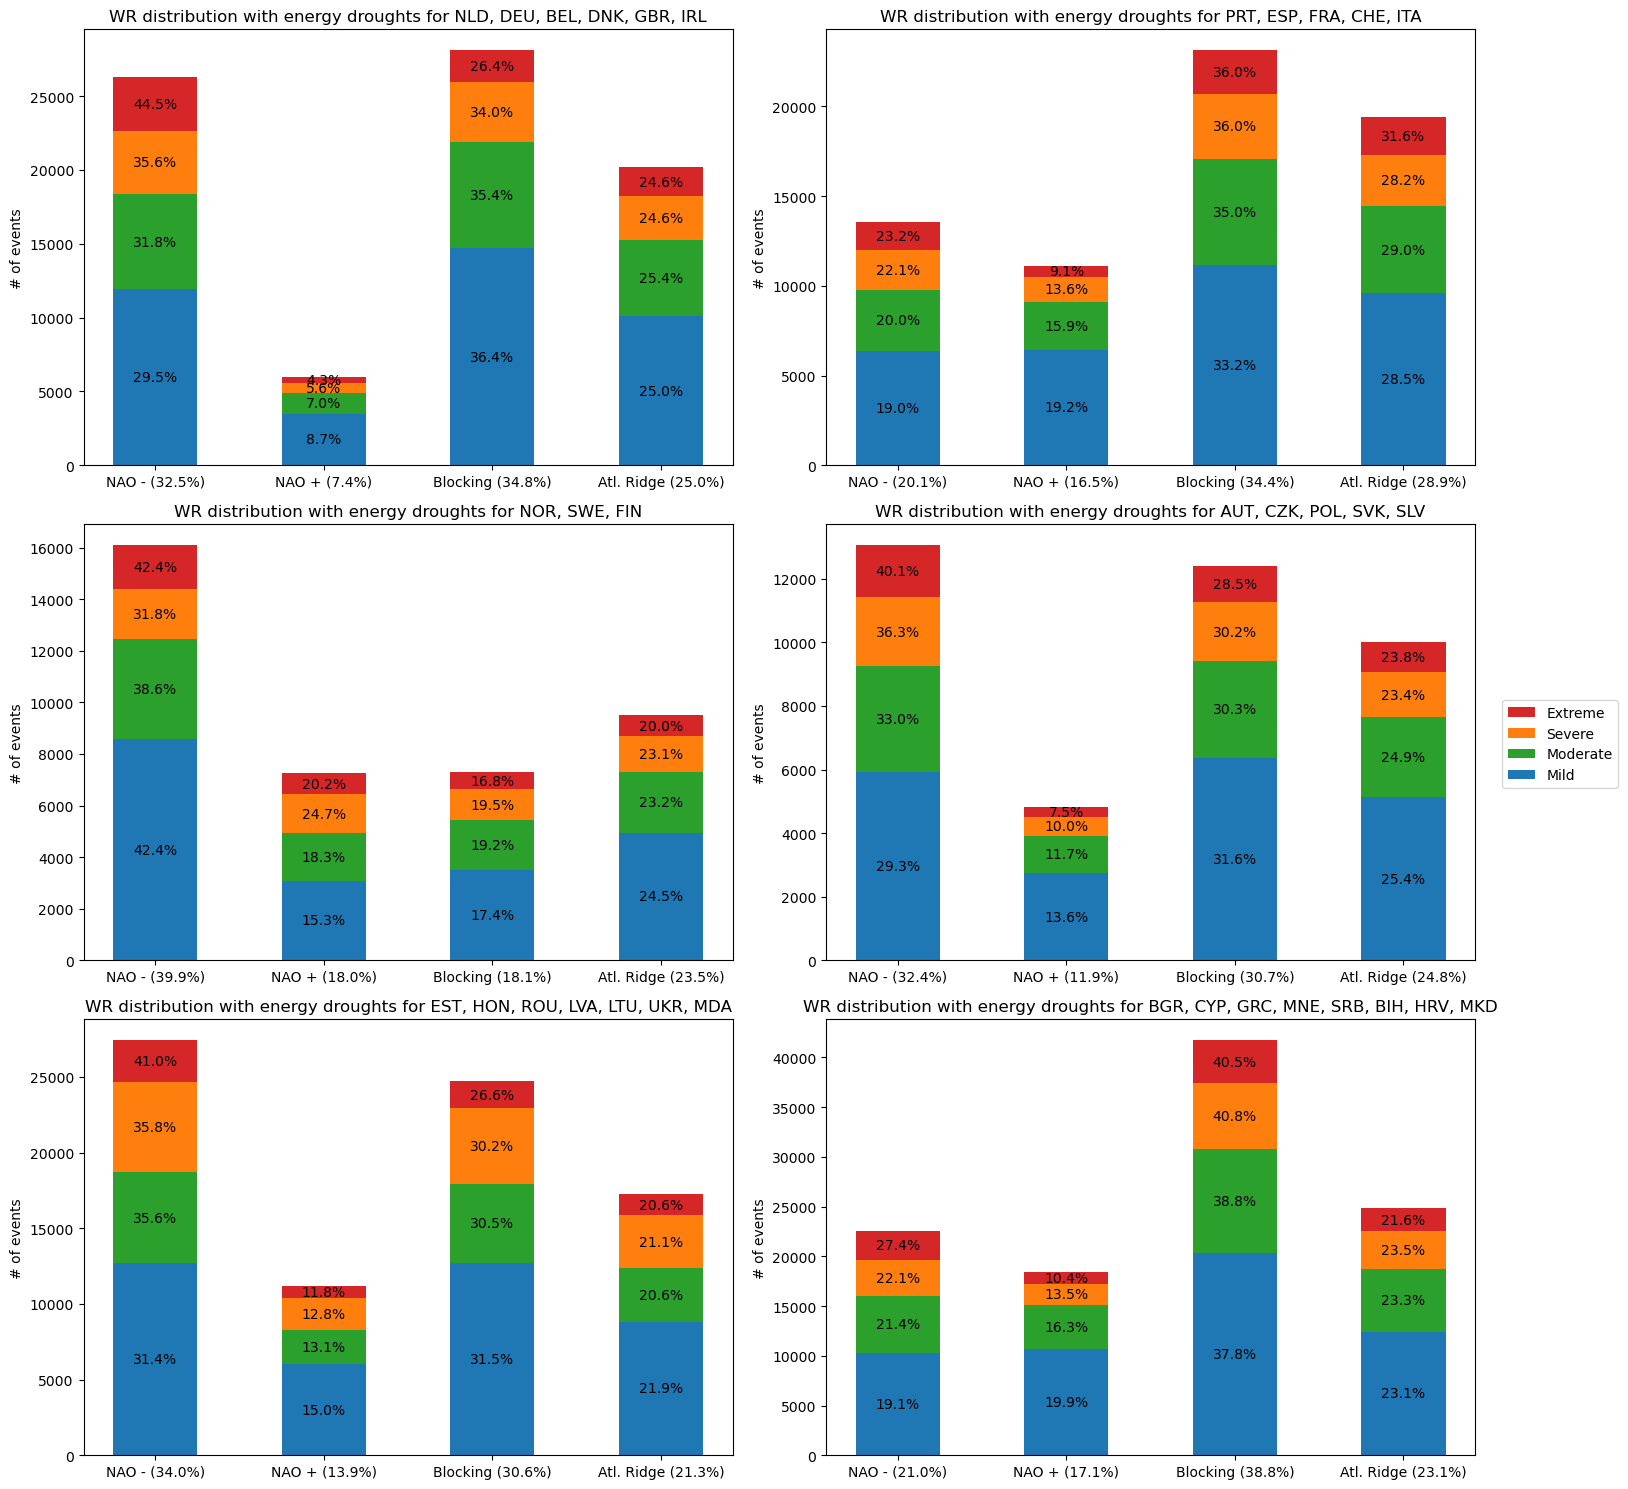

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

SW = ['PRT', 'ESP', 'FRA', 'CHE', 'ITA']
NW = ['NLD', 'DEU', 'BEL', 'DNK', 'GBR', 'IRL']
N = ['NOR', 'SWE', 'FIN']
C = ['AUT', 'CZK', 'POL', 'SVK', 'SLV']
E = ['EST',  'HON', 'ROU', 'LVA', 'LTU', 'UKR', 'MDA']
SE = ['BGR', 'CYP', 'GRC', 'MNE', 'SRB', 'BIH', 'HRV', 'MKD']

cluster_histogram_list(df_xr, NW, axs[0, 0])
cluster_histogram_list(df_xr, SW, axs[0, 1])
cluster_histogram_list(df_xr, N, axs[1, 0])
cluster_histogram_list(df_xr, C, axs[1, 1])
cluster_histogram_list(df_xr, E, axs[2, 0])
cluster_histogram_list(df_xr, SE, axs[2, 1])

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


### Risk ratio per WR

In [33]:
def cluster_risk(df_xr, country_list):
    df_naomin = df_xr[(df_xr['cluster_id'] == 0) & df_xr['country_name'].isin(country_list) & df_xr['residual'].between(0.9, 1)]
    df_naoplus = df_xr[(df_xr['cluster_id'] == 1) & df_xr['country_name'].isin(country_list) & df_xr['residual'].between(0.9, 1)]
    df_block = df_xr[(df_xr['cluster_id'] == 2) & df_xr['country_name'].isin(country_list) & df_xr['residual'].between(0.9, 1)]
    df_ridge = df_xr[(df_xr['cluster_id'] == 3) & df_xr['country_name'].isin(country_list) & df_xr['residual'].between(0.9, 1)]
    df_all = df_xr[df_xr['country_name'].isin(country_list) & df_xr['residual'].between(0.9, 1)]

    r_naomin = (len(df_naomin)/len(df_all) * 100) / 25
    r_naoplus = (len(df_naoplus)/len(df_all) * 100) / 25
    r_block = (len(df_block)/len(df_all) * 100) / 25
    r_ridge = (len(df_ridge)/len(df_all) * 100) / 25
    risks = [r_naomin, r_naoplus, r_block, r_ridge]
    return risks

In [35]:
risks_NW = cluster_risk(df_xr, NW)
risks_SW = cluster_risk(df_xr, SW)
risks_N = cluster_risk(df_xr, N)
risks_C = cluster_risk(df_xr, C)
risks_E = cluster_risk(df_xr, E)
risks_SE = cluster_risk(df_xr, SE)

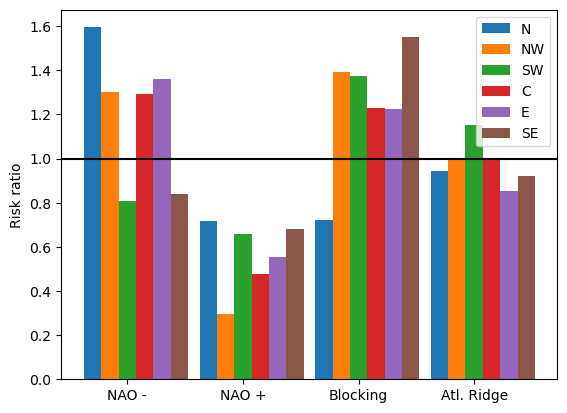

In [41]:
labels = ['NAO -', 'NAO +', 'Blocking', 'Atl. Ridge']
num_conditions = len(labels)

width = 0.15
positions = np.arange(num_conditions)

plt.bar(positions - 2*width, risks_N, width, label='N')
plt.bar(positions - width, risks_NW, width, label='NW')
plt.bar(positions, risks_SW, width, label='SW')
plt.bar(positions + width, risks_C, width, label='C')
plt.bar(positions + 2*width, risks_E, width, label='E')
plt.bar(positions + 3*width, risks_SE, width, label='SE')

plt.axhline(y=1, color='k', linestyle='-')
plt.ylabel('Risk ratio')
plt.xticks(positions, labels) 
plt.legend()

### Heatmaps with co-variability percentiles

In [152]:
date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
dir_Output = f'../Results/Data/{rundate}/{variable}/droughtpercentiles/'
dir_Figures = f'../Results/Figures/{rundate}/{variable}/droughtpercentiles/'

if not os.path.exists(dir_Output):
    print('Creating dir %s' % dir_Output)
    os.makedirs(dir_Output)

if not os.path.exists(dir_Figures):
    print('Creating dir %s' % dir_Figures)
    os.makedirs(dir_Figures)

Creating dir ../Results/Data/20231220/total_RE/droughtpercentiles/
Creating dir ../Results/Figures/20231220/total_RE/droughtpercentiles/


In [153]:
COUNTRY_NR = res_stacked.country.values
COUNTRY_NAME = res_stacked.country_name.values
country_nr_name = dict(zip(COUNTRY_NR, COUNTRY_NAME))
country_name_nr  = dict(zip(COUNTRY_NAME, COUNTRY_NR))

HOMEDIR = '/usr/people/duinen/MSc-thesis/'
ROW_ORDER = np.load(f'{HOMEDIR}Data/row_order_v20231215.npy') # load the row ordering of the clustered residual heatmap, to follow the same clustering!
CMAP = 'RdBu_r'
tocluster = False # only has to be done once, from then stick with the same ordering

In [154]:
mild = (res_rank > 0.90) & (res_rank < 0.95)
moderate = (res_rank > 0.95) & (res_rank < 0.975)
severe = (res_rank > 0.975) & (res_rank < 0.99)
extreme = (res_rank > 0.99)

In [155]:
def calc_perc(thres, data, threstype):
    perc_matrix = np.zeros((len(COUNTRY_NR), len(COUNTRY_NR)))

    for i, c_id in enumerate(COUNTRY_NR):
        c1_event = thres.sel(country = c_id).values
        for j, c2_id in enumerate(COUNTRY_NR):
            perc_matrix[i, j] = np.median(data.sel(country = c2_id).values[c1_event]) # median not really the best choice, I think

    # np.save(f'{dir_Output}{threstype}.npy', perc_matrix)
    return perc_matrix

In [156]:
def calc_perc_mean(thres, data, threstype):
    perc_matrix = np.zeros((len(COUNTRY_NR), len(COUNTRY_NR)))

    for i, c_id in enumerate(COUNTRY_NR):
        c1_event = thres.sel(country = c_id).values
        for j, c2_id in enumerate(COUNTRY_NR):
            perc_matrix[i, j] = np.mean(data.sel(country = c2_id).values[c1_event]) # Try using mean as well

    np.save(f'{dir_Output}{threstype}.npy', perc_matrix)
    return perc_matrix

In [157]:
def reorder(matrix):
    df_matrix = pd.DataFrame(matrix)

    matrix_reordered = df_matrix.reindex(ROW_ORDER, axis=0)
    matrix_reordered = matrix_reordered.reindex(ROW_ORDER, axis=1)
    return matrix_reordered.values

In [158]:
def clustering(thres, data, threstype): 
    matrix = calc_perc(thres, data, threstype)

    link = linkage(matrix)

    cg = sns.clustermap(matrix, row_linkage=link, col_linkage=link, cmap=CMAP, method = 'ward', norm=TwoSlopeNorm(vcenter=0.8), xticklabels = COUNTRY_NAME, yticklabels = COUNTRY_NAME)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    x0, _y0, _w, _h = cg.cbar_pos
    cg.ax_cbar.set_position([1, 0.06, 0.025, 0.74])
    row_order = cg.dendrogram_row.reordered_ind
    np.save(f'../Data/row_order_v{rundate}.npy', row_order)

In [159]:
if tocluster:
    clustering(mild, res_rank, 'mild')

In [160]:
mildmatrix = calc_perc(mild, res_rank, 'mild')

Median

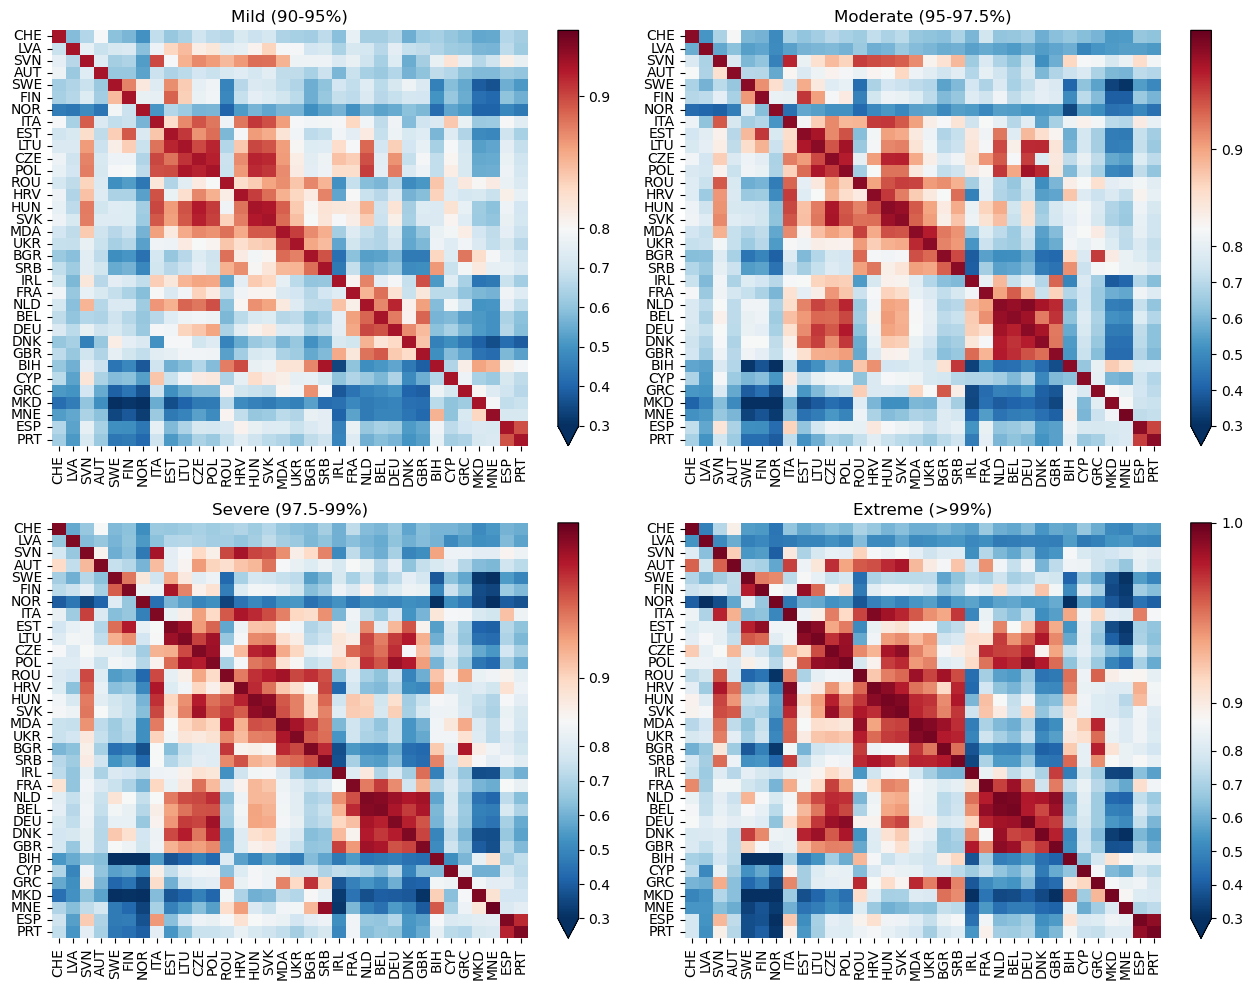

In [161]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

data_list = [mild, moderate, severe, extreme]
vcenter_list = [0.8, 0.85, 0.875, 0.89]
vmax_list = [0.95, 0.975, 0.99, 1]

type_list = ['mild', 'moderate', 'severe', 'extreme']
drought_types = ['Mild (90-95%)', 'Moderate (95-97.5%)', 'Severe (97.5-99%)', 'Extreme (>99%)']

for ax, data, vcenter, vmax, title, threstype in zip(axs.flatten(), data_list, vcenter_list, vmax_list, drought_types, type_list):
    hm = sns.heatmap(reorder(calc_perc(data, res_rank, threstype)), cmap='RdBu_r', cbar = False, xticklabels=COUNTRY_NAME[ROW_ORDER], 
                yticklabels=COUNTRY_NAME[ROW_ORDER], norm=TwoSlopeNorm(vmin = 0.3, vcenter=vcenter, vmax=vmax), ax=ax)
    ax.set_title(title)
    plt.colorbar(hm.collections[0], ax=ax, extend='min')

plt.tight_layout()
plt.savefig(f'{dir_Figures}mediandroughtpercentiles.png', dpi = 300)

Mean

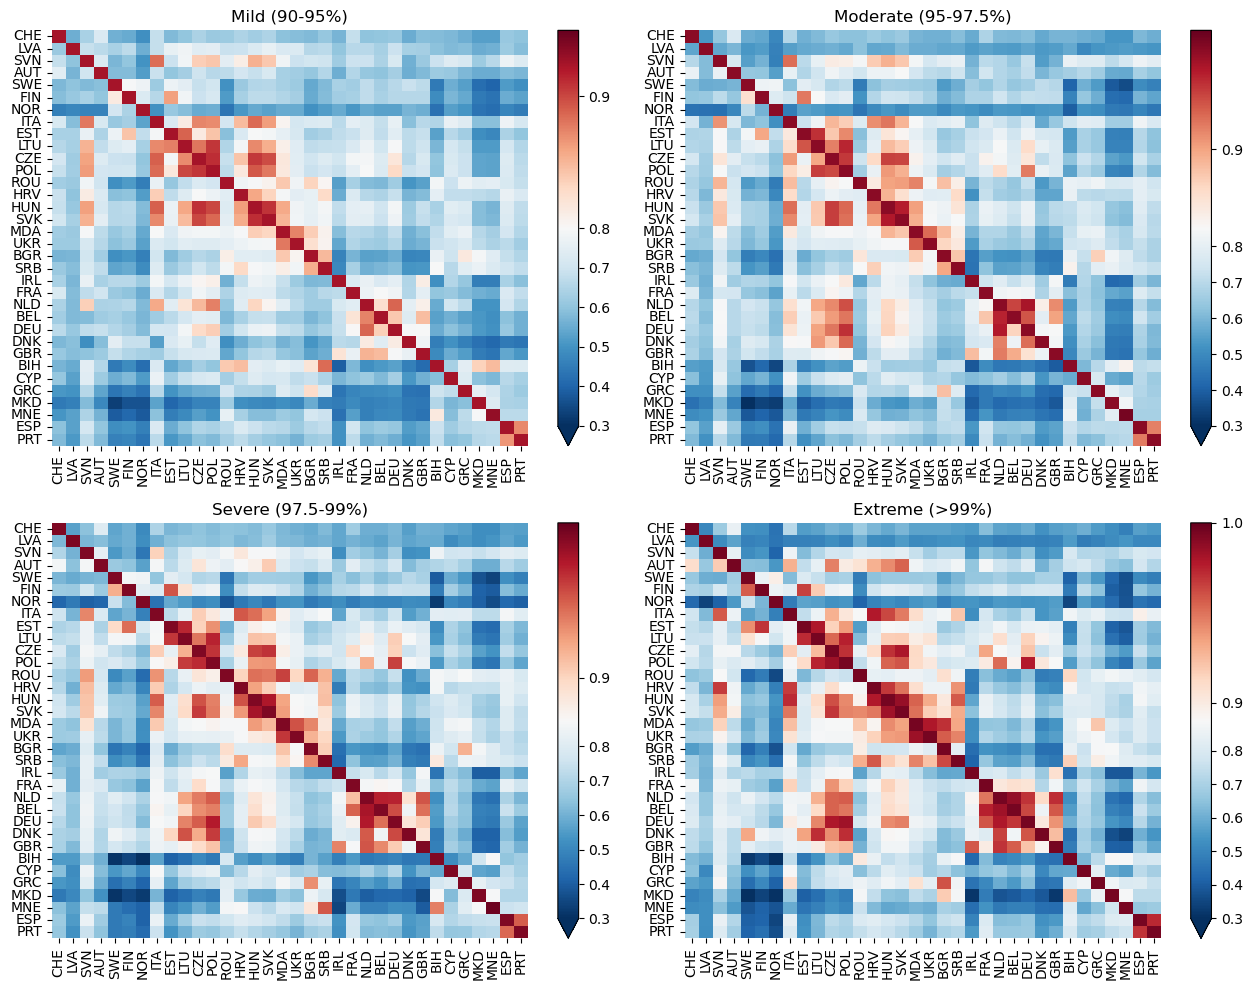

In [162]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

data_list = [mild, moderate, severe, extreme]
vcenter_list = [0.8, 0.85, 0.875, 0.89]
vmax_list = [0.95, 0.975, 0.99, 1]

type_list = ['mild', 'moderate', 'severe', 'extreme']
drought_types = ['Mild (90-95%)', 'Moderate (95-97.5%)', 'Severe (97.5-99%)', 'Extreme (>99%)']

for ax, data, vcenter, vmax, title, threstype in zip(axs.flatten(), data_list, vcenter_list, vmax_list, drought_types, type_list):
    hm = sns.heatmap(reorder(calc_perc_mean(data, res_rank, threstype)), cmap='RdBu_r', cbar = False, xticklabels=COUNTRY_NAME[ROW_ORDER], 
                yticklabels=COUNTRY_NAME[ROW_ORDER], norm=TwoSlopeNorm(vmin = 0.3, vcenter=vcenter, vmax=vmax), ax=ax)
    ax.set_title(title)
    plt.colorbar(hm.collections[0], ax=ax, extend='min')
    
plt.tight_layout()
plt.savefig(f'{dir_Figures}meandroughtpercentiles.png', dpi = 300)

Analyse PDFs

In [163]:
def calc_perc_pdf(thres, data, c1_name, c2_name):
    c1_event = thres.sel(country = country_name_nr[c1_name]).values
    pdf_c2 = data.sel(country = country_name_nr[c2_name]).values[c1_event]
    return pdf_c2, np.mean(pdf_c2), np.median(pdf_c2)

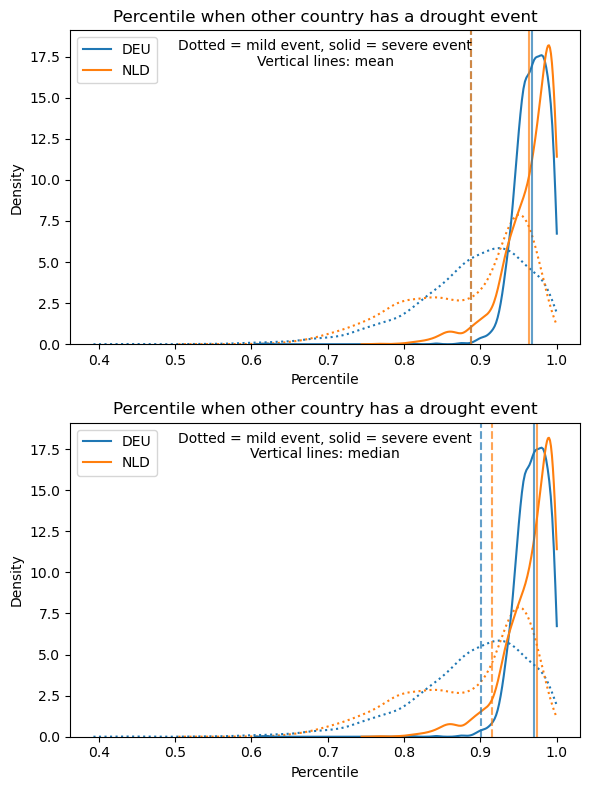

In [164]:
c1_name = 'NLD'
c2_name = 'DEU'

fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# First plot
sns.kdeplot(calc_perc_pdf(mild, res_rank, c2_name, c1_name)[0], clip = (0,1), color = 'C0', linestyle = 'dotted', ax=axs[0])
sns.kdeplot(calc_perc_pdf(mild, res_rank, c1_name, c2_name)[0], clip = (0,1), color = 'C1',linestyle = 'dotted', ax=axs[0])
sns.kdeplot(calc_perc_pdf(severe, res_rank, c2_name, c1_name)[0], clip = (0,1), color = 'C0', label = c2_name, ax=axs[0])
sns.kdeplot(calc_perc_pdf(severe, res_rank, c1_name, c2_name)[0], clip = (0,1), color = 'C1', label = c1_name, ax=axs[0])

axs[0].axvline(calc_perc_pdf(mild, res_rank, c2_name, c1_name)[1], color='C0', linestyle='--', alpha = 0.7)
axs[0].axvline(calc_perc_pdf(mild, res_rank, c1_name, c2_name)[1], color='C1', linestyle='--', alpha = 0.7)
axs[0].axvline(calc_perc_pdf(severe, res_rank, c2_name, c1_name)[1], color='C0', alpha = 0.7)
axs[0].axvline(calc_perc_pdf(severe, res_rank, c1_name, c2_name)[1], color='C1', alpha = 0.7)

axs[0].legend()
axs[0].set_xlabel('Percentile')
axs[0].set_title("Percentile when other country has a drought event")
axs[0].annotate('Dotted = mild event, solid = severe event', (0.5,0.95), xycoords='axes fraction', ha='center', va='center')
axs[0].annotate('Vertical lines: mean', (0.5,0.9), xycoords='axes fraction', ha='center', va='center')

# Second plot
sns.kdeplot(calc_perc_pdf(mild, res_rank, c2_name, c1_name)[0], clip = (0,1), color = 'C0', linestyle = 'dotted', ax=axs[1])
sns.kdeplot(calc_perc_pdf(mild, res_rank, c1_name, c2_name)[0], clip = (0,1), color = 'C1',linestyle = 'dotted', ax=axs[1])
sns.kdeplot(calc_perc_pdf(severe, res_rank, c2_name, c1_name)[0], clip = (0,1), color = 'C0', label = c2_name, ax=axs[1])
sns.kdeplot(calc_perc_pdf(severe, res_rank, c1_name, c2_name)[0], clip = (0,1), color = 'C1', label = c1_name, ax=axs[1])

axs[1].axvline(calc_perc_pdf(mild, res_rank, c2_name, c1_name)[2], color='C0', linestyle='--', alpha = 0.7)
axs[1].axvline(calc_perc_pdf(mild, res_rank, c1_name, c2_name)[2], color='C1', linestyle='--', alpha = 0.7)
axs[1].axvline(calc_perc_pdf(severe, res_rank, c2_name, c1_name)[2], color='C0', alpha = 0.7)
axs[1].axvline(calc_perc_pdf(severe, res_rank, c1_name, c2_name)[2], color='C1', alpha = 0.7)

axs[1].legend()
axs[1].set_xlabel('Percentile')
axs[1].set_title("Percentile when other country has a drought event")
axs[1].annotate('Dotted = mild event, solid = severe event', (0.5,0.95), xycoords='axes fraction', ha='center', va='center')
axs[1].annotate('Vertical lines: median', (0.5,0.9), xycoords='axes fraction', ha='center', va='center')

plt.tight_layout()
plt.savefig(f'{dir_Figures}pdf_{c1_name}vs{c2_name}.png', dpi = 300)